# Obtaining AQI Data
This notebook is an adaptation of a notebook written by Dr. David W. McDonald for the DATA 512 cource part of the UW MS Data Science program. Except for the final few cells and a few lines, this notebook is almost a direct copy from Professor McDonald's notebook, largely due to the fact it was leveraged with reference code to acquire AQI data and read the data in an efficient manner via the EPA AQS API.

## Assumptions
1. All instructions below have been followed, such as creating an account with the EPA to obtain an API key.
2. The only city of inquiry for this notebook is Gainesville, FL, thus all AQI measurements obtained are from the closest Air Quality Service station located in Paynes Prairie Preserve State Park in Alachua County, FL.

## Goals
The goal is to obtain daily AQI measurements from the Alachua Count, FL AQS station dating back to 1973 to present day. This notebook helps procure the data and then parse it as the resulting data is quite nested and complicated.

## Outputs
Each day of measurements is split into Particle and Gaseous pollutants and an associated AQI for each.
Each measurement has a number of features but the following will be extracted:
1. sample_duration: How often a sample is taken
2. sample_duration_code: Code used by EPA to know what sample_duration is
3. observation_count: The observation made for the day (example 4th or 5th etc)
4. arithmetic_mean
5. aqi: The calculated AQI for that given measurement
6. date_local: The local date and time in Year-Day-Month format

The features above are then associated with the date the sample was taken and grouped together based on the pollutant measured being gaseous or particle based. The final two data products from this notebook will be:
1. gas_output.csv
2. particulate_output.csv

# US EPA Air Quality System API Example
This example illustrates how to request data from the US Environmental Protection Agency (EPA) Air Quality Service (AQS) API. This is a historical API and does not provide real-time air quality data. The [documentation](https://aqs.epa.gov/aqsweb/documents/data_api.html) for the API provides definitions of the different call parameter and examples of the various calls that can be made to the API.

This notebook works systematically through example calls, requesting an API key, using 'list' to get various IDs and parameter values, and using 'daily summary' to get summary data that meets specific condistions. The notebook contains example function definitions that could be reused in other code. In general, the notebook explains each step along the way, referring back to possible output. Some of the explanations are tailored to the specific example requests of the API. Changing values to explore the results of the API is probably useful, but that will result in some explanations being out of sync with the outputs.

The US EPA was created in the early 1970's. The EPA reports that they only started broad based monitoring with standardized quality assurance procedures in the 1980's. Many counties will have data starting somewhere between 1983 and 1988. However, some counties still do not have any air quality monitoring stations. The API helps resolve this by providing calls to search for monitoring stations and data using either station ids, or a county designation or a geographic bounding box. This example code provides examples of the county based and bounding box based API calls. Some [additional information on the Air Quality System can be found in the EPA FAQ](https://www.epa.gov/outdoor-air-quality-data/frequent-questions-about-airdata) on the system.

The end goal of this example is to get to some values that we might use for the Air Quality Index or AQI. You might see this reported on the news, most often around smog, but more frequently with regard to smoke. The AQI index is meant to tell us something about how healthy or clean the air is on any day. The AQI is actually a somewhat complext measure. When I started this example I looked up [how to calculate the AQI](https://www.airnow.gov/sites/default/files/2020-05/aqi-technical-assistance-document-sept2018.pdf) so that I would know roughly what goes into that value.


## License
This code example was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.2 - August 16, 2024



In [29]:
# 
#    These are standard python modules
#
#import json, time, urllib.parse
import json, time
#
#    The 'requests' module is a distribution module for making web requests. If you do not have it already, you'll need to install it
import requests
import pandas as pd

In [2]:
#########
#
#    CONSTANTS
#

#
#    This is the root of all AQS API URLs
#
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'

#
#    These are some of the 'actions' we can ask the API to take or requests that we can make of the API
#
#    Sign-up request - generally only performed once - unless you lose your key
API_ACTION_SIGNUP = '/signup?email={email}'
#
#    List actions provide information on API parameter values that are required by some other actions/requests
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'
#
#    Monitor actions are requests for monitoring stations that meet specific criteria
API_ACTION_MONITORS_COUNTY = '/monitors/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_MONITORS_BOX = '/monitors/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    Summary actions are requests for summary data. These are for daily summaries
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_BOX = '/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    It is always nice to be respectful of a free data resource.
#    We're going to observe a 100 requests per minute limit - which is fairly nice
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED
#
#
#    This is a template that covers most of the parameters for the actions we might take, from the set of actions
#    above. In the examples below, most of the time parameters can either be supplied as individual values to a
#    function - or they can be set in a copy of the template and passed in with the template.
# 
AQS_REQUEST_TEMPLATE = {
    "email":      "",     
    "key":        "",      
    "state":      "",     # the two digit state FIPS # as a string
    "county":     "",     # the three digit county FIPS # as a string
    "begin_date": "",     # the start of a time window in YYYYMMDD format
    "end_date":   "",     # the end of a time window in YYYYMMDD format, begin_date and end_date must be in the same year
    "minlat":    0.0,
    "maxlat":    0.0,
    "minlon":    0.0,
    "maxlon":    0.0,
    "param":     "",     # a list of comma separated 5 digit codes, max 5 codes requested
    "pclass":    ""      # parameter class is only used by the List calls
}



## Example 1. Making a sign-up request

Before you can use the API you need to request a key. You will use an email address to make the request. The EPA then sends a confirmation email link and a 'key' that you use for all other requests.

You only need to sign-up once, unless you want to invalidate your current key (by getting a new key) or you lose your key.


In [3]:
#
#    This implements the sign-up request. The parameters are standardized so that this function definition matches
#    all of the others. However, the easiest way to call this is to simply call this function with your preferred
#    email address.
#
def request_signup(email_address = None,
                   endpoint_url = API_REQUEST_URL, 
                   endpoint_action = API_ACTION_SIGNUP, 
                   request_template = AQS_REQUEST_TEMPLATE,
                   headers = None):
    
    # Make sure we have a string - if you don't have access to this email addres, things might go badly for you
    if email_address:
        request_template['email'] = email_address        
    
    if not request_template['email']: 
        raise Exception("Must supply an email address to call 'request_signup()'")

    if '@' not in request_template['email']: 
        raise Exception(f"Must supply an email address to call 'request_signup()'. The string '{request_template['email']}' does not look like an email address.")

    # Compose the signup url - create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response




In [4]:
#
#    A SIGNUP request is only to be done once, to request a key. A key is sent to that email address and needs to be confirmed with a click through
#    This code should probably be commented out after you've made your key request to make sure you don't accidentally make a new sign-up request
#
#print("Requesting SIGNUP ...")
#USERNAME = "<your_email_address>"
#response = request_signup(USERNAME)
#print(json.dumps(response,indent=4))
#

A response to the signup request might look something like this.


    Requesting SIGNUP ...
    {
        "Header": [
            {
                "status": "Success",
                "request_time": "2023-08-07T17:03:27-04:00",
                "url": "https://aqs.epa.gov/data/api/signup?email=dwmc@uw.edu"
            }
        ],
        "Data": [
            "You should receive a registration confirmation email with a link for confirming your email shortly."
        ]
    }



**Note:** The code below relies on a user module called apikeys that is a key manager. You don't need that to make this code work. You can use the email you used for your sign-up request and the key that you got in email. Assign your email address to "USERNAME" and your key to "APIKEY" as constants and the remaining cells in the notbook should work.

In [4]:
#
#   Once we have the signup email, we can define two constants:
#
#   USERNAME - This should be the email address you sent the EPA asking for access to the API during sign-up
#   APIKEY   - This should be the authorization key they sent you
#
#   In this case I don't want to distribute my keys with the source of the notebook, so I wrote a key manager object that
#   helps track all of my API keys - a username and domain name retrieves the key. The key manager hides the keys on disk
#   separate from the code. Another common approach is to store your API key as an OS environment variable. You then use
#   a python package to extract that API key from the specific environment variable.
#
#from apikeys.KeyManager import KeyManager
#keyman = KeyManager()
##
#   Naturally, you should probably use the USERNAME that you used when you requested the API Key. I've used my email
#   address as my USERNAME when I added the API Key to the Key manager. This will look it up for me.
#USERNAME = "dwmc@uw.edu"
#key_info = keyman.findRecord(USERNAME,API_REQUEST_URL)
#APIKEY = key_info[0]['key']
#print(key_info[0]['description'])
#print(APIKEY)
#
#   Note: if you don't want to use the key manager to help manage your API keys, you can specify the values as constants
#   below. Just don't distribute the notebook without removing the constants or you'll be distributing your key too.
#
USERNAME = "dtropf@uw.edu"
APIKEY = "" # Must obtain your own key here.


## Example 2. Making a list request
Once you have a key, the next thing is to get information about the different types of air quality monitoring (sensors) and the different places where we might find air quality stations. The monitoring system is complex and changes all the time. The EPA implementation allows an API user to find changes to monitoring sites and sensors by making requests - maybe monthly, or daily. This API approach is probably better than having the EPA publish documentation that may be out of date as soon as it hits a web page. The one problem here is that some of the responses rely on jargon or terms-of-art. That is, one needs to know a bit about the way atmospheric sciece works to understand some of the terms. ... Good thing we can use the web to search for terms we don't know!

In [5]:
#
#    This implements the list request. There are several versions of the list request that only require email and key.
#    This code sets the default action/requests to list the groups or parameter class descriptors. Having those descriptors 
#    allows one to request the individual (proprietary) 5 digit codes for individual air quality measures by using the
#    param request. Some code in later cells will illustrate those requests.
#
def request_list_info(email_address = None, key = None,
                      endpoint_url = API_REQUEST_URL, 
                      endpoint_action = API_ACTION_LIST_CLASSES, 
                      request_template = AQS_REQUEST_TEMPLATE,
                      headers = None):
    
    #  Make sure we have email and key - at least
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    
    # For the basic request we need an email address and a key
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_list_info()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_list_info()'")

    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response



In [6]:
#
#   The default should get us a list of the various groups or classes of sensors. These classes are user defined names for clustors of
#   sensors that might be part of a package or default air quality sensing station. We need a class name to start getting down to the
#   a sensor ID. Each sensor type has an ID number. We'll eventually need those ID numbers to be able to request values that come from
#   that specific sensor.
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY

response = request_list_info(request_template=request_data)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


[
    {
        "code": "AIRNOW MAPS",
        "value_represented": "The parameters represented on AirNow maps (88101, 88502, and 44201)"
    },
    {
        "code": "ALL",
        "value_represented": "Select all Parameters Available"
    },
    {
        "code": "AQI POLLUTANTS",
        "value_represented": "Pollutants that have an AQI Defined"
    },
    {
        "code": "CORE_HAPS",
        "value_represented": "Urban Air Toxic Pollutants"
    },
    {
        "code": "CRITERIA",
        "value_represented": "Criteria Pollutants"
    },
    {
        "code": "CSN DART",
        "value_represented": "List of CSN speciation parameters to populate the STI DART tool"
    },
    {
        "code": "FORECAST",
        "value_represented": "Parameters routinely extracted by AirNow (STI)"
    },
    {
        "code": "HAPS",
        "value_represented": "Hazardous Air Pollutants"
    },
    {
        "code": "IMPROVE CARBON",
        "value_represented": "IMPROVE Carbon Parameters"
    }

We're interested in getting to something that might be the Air Quality Index (AQI). You see this reported on the news - often around smog values, but also when there is smoke in the sky. The AQI is a complex measure of different gasses and of the particles in the air (dust, dirt, ash ...).

From the list produced by our 'list/Classes' request above, it looks like there is a class of sensors called "AQI POLLUTANTS". Let's try to get a list of those specific sensors and see what we can get from those.


In [7]:
#
#   Once we have a list of the classes or groups of possible sensors, we can find the sensor IDs that make up that class (group)
#   The one that looks to be associated with the Air Quality Index is "AQI POLLUTANTS"
#   We'll use that to make another list request.
#
AQI_PARAM_CLASS = "AQI POLLUTANTS"


In [8]:
#
#   Structure a request to get the sensor IDs associated with the AQI
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['pclass'] = AQI_PARAM_CLASS  # here we specify that we want this 'pclass' or parameter classs

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_PARAMS)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


[
    {
        "code": "42101",
        "value_represented": "Carbon monoxide"
    },
    {
        "code": "42401",
        "value_represented": "Sulfur dioxide"
    },
    {
        "code": "42602",
        "value_represented": "Nitrogen dioxide (NO2)"
    },
    {
        "code": "44201",
        "value_represented": "Ozone"
    },
    {
        "code": "81102",
        "value_represented": "PM10 Total 0-10um STP"
    },
    {
        "code": "88101",
        "value_represented": "PM2.5 - Local Conditions"
    },
    {
        "code": "88502",
        "value_represented": "Acceptable PM2.5 AQI & Speciation Mass"
    }
]


We should now have (above) a response containing a set of sensor ID numbers. The list should include the sensor numbers as well as a description or name for each sensor. 

The EPA AQS API has limits on some call parameters. Specifically, when we request data for sensors we can only specify a maximum of 5 different sensor values to return. This means we cannot get all of the Air Quality Index parameters in one request for data. We have to break it up.

What I did below was to break the request into two logical groups, the AQI sensors that sample gasses and the AQI sensors that sample particles in the air.

In [9]:
#
#   Given the set of sensor codes, now we can create a parameter list or 'param' value as defined by the AQS API spec.
#   It turns out that we want all of these measures for AQI, but we need to have two different param constants to get
#   all seven of the code types. We can only have a max of 5 sensors/values request per param.
#
#   Gaseous AQI pollutants CO, SO2, NO2, and O2
AQI_PARAMS_GASEOUS = "42101,42401,42602,44201"
#
#   Particulate AQI pollutants PM10, PM2.5, and Acceptable PM2.5
AQI_PARAMS_PARTICULATES = "81102,88101,88502"
#   
#

Air quality monitoring stations are located all over the US at different locations. We will need some sample locations to experiment with different locations to see what kinds of values come back from different sensor requests.

This list includes the [FIPS](https://www.census.gov/library/reference/code-lists/ansi.html) number for the state and county as a 5 digit string. This format, the 5 digit string, is a 'old' format that is still widely used. There are new codes that may eventually be adopted for the US government information systems. But FIPS is currently what the AQS uses, so that's what is in the list as the constant.

Just two example cities to explore.

In [16]:
#
#   We'll use these two city locations in the examples below.
#
CITY_LOCATIONS = {
    'seaside' :       {'city'   : 'Seaside',
                       'county' : 'Clatsop',
                       'state'  : 'Oregon',
                       'fips'   : '41007',
                       'latlon' : [45.9932, -123.9226] }, 
    'bend' :          {'city'   : 'Bend',
                       'county' : 'Deschutes',
                       'state'  : 'Oregon',
                       'fips'   : '41017',
                       'latlon' : [44.0582, -121.3153] },
    "loveland" :      {"city"   : "Loveland",
                       "county" : "Larimer",
                       "state"  : ["Colorado", "CO"],
                       "fips"   : "08069",
                       "monitoring_start_year" : 0,
                       "area"   : 22760.0,
                       "pop."   : 76378,
                       "latlon" : [40.398857, -105.052643] },
    "gainesville":   {"city": "Gainesville",
                       "county": "Alachua",
                       "fips": '12001',
                       "state": "Florida",
                       "latlon": [29.68, -82.35] }
}


Given our CITY_LOCATIONS constant we can now find which monitoring locations are nearby. One option is to use the county to define the area we're interest in. You can get the EPA to list their monitoring stations by county. You can also get a set of monitoring stations by using a bounding box of latitude, longitude points. For this example, we'll use the county approach. There is a bounding box example later in this notebook.

In [17]:
#
#  This list request should give us a list of all the monitoring stations in the county specified by the
#  given city selected from the CITY_LOCATIONS dictionary
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['state'] = CITY_LOCATIONS['gainesville']['fips'][:2]   # the first two digits (characters) of FIPS is the state code
request_data['county'] = CITY_LOCATIONS['gainesville']['fips'][2:]  # the last three digits (characters) of FIPS is the county code

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_SITES)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


[
    {
        "code": "0001",
        "value_represented": null
    },
    {
        "code": "0002",
        "value_represented": null
    },
    {
        "code": "0003",
        "value_represented": null
    },
    {
        "code": "0004",
        "value_represented": null
    },
    {
        "code": "0005",
        "value_represented": null
    },
    {
        "code": "0006",
        "value_represented": null
    },
    {
        "code": "0007",
        "value_represented": null
    },
    {
        "code": "0008",
        "value_represented": null
    },
    {
        "code": "0009",
        "value_represented": null
    },
    {
        "code": "0010",
        "value_represented": null
    },
    {
        "code": "0011",
        "value_represented": null
    },
    {
        "code": "0012",
        "value_represented": null
    },
    {
        "code": "0013",
        "value_represented": null
    },
    {
        "code": "0014",
        "value_represented": null
    },
    


The above response gives us a list of monitoring stations. Each monitoring station has a unique "code" which is a string number, and, sometimes, a description. The description seems to be something about where the monitoring station is located.


## Example 3. Making a daily summary request

The function below is designed to encapsulate requests to the EPA AQS API. When calling the function one should create/copy a parameter template, then initialize that template with values that won't change with each call. Then on each call simply pass in the parameters that need to change, like date ranges.

Another function below provides an example of extracting values and restructuring the response to make it a little more usable.

In [20]:
#
#    This implements the daily summary request. Daily summary provides a daily summary value for each sensor being requested
#    from the start date to the end date. 
#
#    Like the two other functions, this can be called with a mixture of a defined parameter dictionary, or with function
#    parameters. If function parameters are provided, those take precedence over any parameters from the request template.
#
def request_daily_summary(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL, 
                          endpoint_action = API_ACTION_DAILY_SUMMARY_COUNTY, 
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):
    
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]            

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_daily_summary()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_daily_summary()'")
    if not request_template['param']: 
        raise Exception("Must supply param values to call 'request_daily_summary()'")
    if not request_template['begin_date']: 
        raise Exception("Must supply a begin_date to call 'request_daily_summary()'")
    if not request_template['end_date']: 
        raise Exception("Must supply an end_date to call 'request_daily_summary()'")
    # Note we're not validating FIPS fields because not all of the daily summary actions require the FIPS numbers
        
    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response



## Creating Data Products

Below is the extraction of specific fields from daily AQI measurements during the regular fire season between May and October of each year from 1961 to 2022.

The specifically extracted features are grouped according to particulate and gaseous pollutants.

Before saving out the data to `.csv` format, pandas dataframes are created from each group, a time series plot is made, and a transformation of the `date_local` freature is made to `datetime` datatype.

In [66]:
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['param'] = AQI_PARAMS_GASEOUS
request_data['state'] = CITY_LOCATIONS['gainesville']['fips'][:2]
request_data['county'] = CITY_LOCATIONS['gainesville']['fips'][2:]

# Daily AQI during fire season for gaseous pollutants
response_list_gas = []
for year in range(1961,2022):
    gaseous_aqi = request_daily_summary(request_template=request_data, begin_date=f"{year}0501", end_date=f"{year}1031")
    #response_list_gas.append(json.dump(gaseous_aqi['Data'],indent=4))
    response_list_gas.append(gaseous_aqi['Data'])

# Daily AQI during fires season for Particulate pollutants
response_list_particulate = []
request_data['param'] = AQI_PARAMS_PARTICULATES
for year in range(1961, 2022):
    particulate_aqi = request_daily_summary(request_template=request_data, begin_date=f"{year}0501", end_date=f"{year}1031")
    #response_list_particulate.append(json.dumps(particulate_aqi['Data'],indent=4))
    response_list_particulate.append(particulate_aqi['Data'])

<Axes: title={'center': 'Time Series of Values'}, xlabel='date_local'>

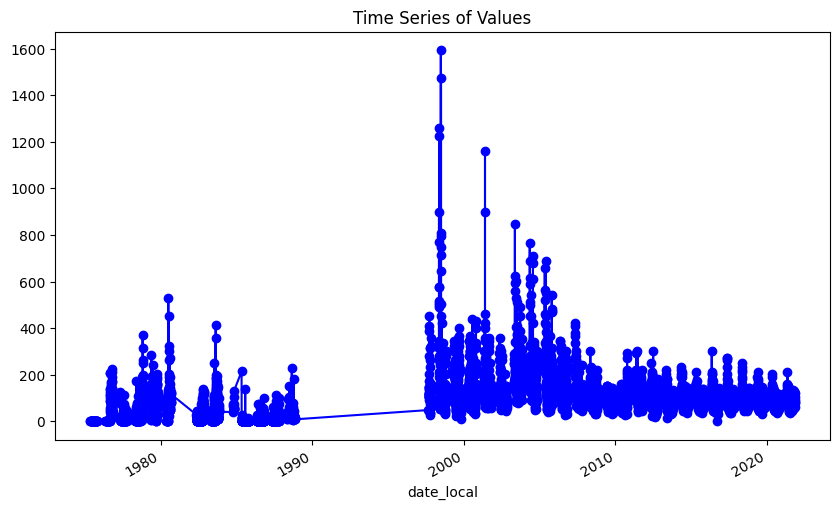

In [81]:
# Extract out specific features, transform the date_local feature to datetime datatype
keys = ['date_local','sample_duration','sample_duration_code','observation_count','arithmetic_mean','aqi']
gas_flat = [item for sublist in response_list_gas for item in sublist]
gdf = pd.DataFrame(gas_flat, columns=keys)

# Plot the daily sum of AQI from 1973 to 2022
gdf['date_local'] = pd.to_datetime(gdf['date_local'])
daily_sum = gdf.groupby('date_local')['aqi'].sum()
daily_sum.plot(figsize=(10, 6), marker='o', color='b', title='Time Series of Values')

In [70]:
keys = ['date_local','sample_duration','sample_duration_code','observation_count','arithmetic_mean','aqi']
particulate_flat = [item for sublist in response_list_particulate for item in sublist]
pdf = pd.DataFrame(particulate_flat, columns=keys)

<Axes: title={'center': 'Time Series of Values'}, xlabel='date_local'>

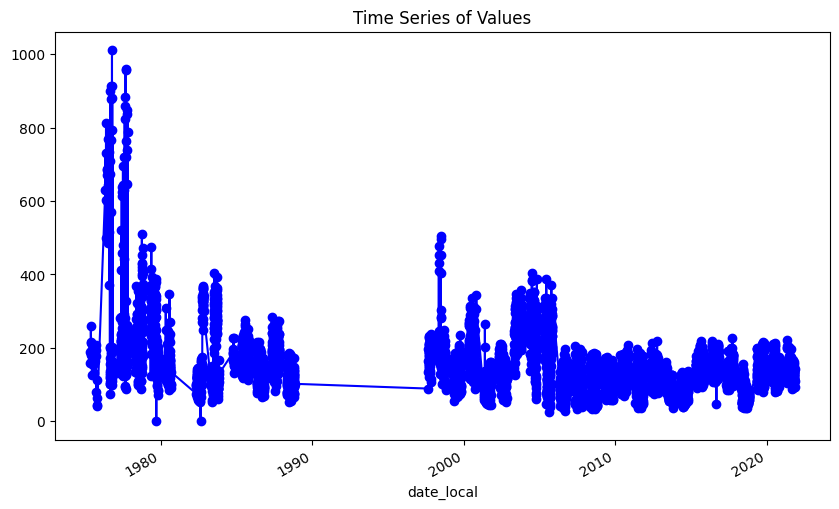

In [77]:
# Convert 'timestamp' column to datetime type
pdf['date_local'] = pd.to_datetime(pdf['date_local'])

# Group by date and sum the values for each day
daily_sum = pdf.groupby('date_local')['aqi'].sum()

daily_sum.plot(figsize=(10, 6), marker='o', color='b', title='Time Series of Values')

In [78]:
# Save AQI measurements
gdf.to_csv('gas_output.csv', index=False)
pdf.to_csv('particulate_output.csv', index=False)